In [1]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score


In [2]:
pd.set_option('display.max_columns', None)

In [28]:
df = pd.read_csv('dataset.csv',index_col=0)

# Prepare data

In [29]:
df.drop(['date_install','first_command_time','birthday','sex','time_confirm_email'],axis=1,inplace=True)

In [30]:
int_cols = df.select_dtypes(include=['int', 'float']).columns
int_cols = int_cols.drop('target_game_currency')
obj_cols = ['country','network_name']

In [31]:
def prepare_obj_data(df, obj_cols):
    '''
    Подготовка колонок с типом данных object
    
    Args:
        df: pd.DataFrame
        obj_cols: list of str 
    Returns:
        pd.DataFrame
    '''
    
    cheat_count_is_cheater = df['is_cheater'].value_counts().index[0]
    cheat_count_has_email = df['has_email'].value_counts().index[0]
    
    df['is_cheater'] = df['is_cheater'].fillna(cheat_count_is_cheater)
    df['has_email'] = df['has_email'].fillna(cheat_count_has_email)
    
    df['country'] = df['country'].fillna('other')
    df['network_name'] = df['network_name'].fillna('other')

    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    for column in obj_cols:
        encoded_data = encoder.fit_transform(df[[column]])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column]))
        df = pd.concat([df, encoded_df], axis=1)
    
    df.drop(obj_cols, axis=1, inplace=True)
        
    return df


In [32]:
df = prepare_obj_data(df, obj_cols)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [33]:
X = df.drop('target_game_currency', axis = 1)
y = df['target_game_currency']

In [34]:
y_stratified = (y > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y_stratified, random_state=42)


## Catboost

In [35]:
def plot_importance(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.feature_importances_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [36]:
def SMAPE(y_true, y_pred):
    """
    SMAPE score
    """
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.where(denominator == 0, 0, 2 * np.abs(y_true - y_pred) / denominator)
    return np.mean(diff)


def custom_smape_score(estimator, X, y):
    '''
    SMAP for cross-validation
    '''
    y_pred = estimator.predict(X)
    smape = SMAPE(y, y_pred)
    return -smape

In [41]:
def train_model(model_obj, X_train, y_train, num_folds ,cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train, verbose=50))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = custom_smape_score)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

0:	learn: 8843.6340269	total: 24.9ms	remaining: 4.96s
50:	learn: 7779.5215484	total: 656ms	remaining: 1.92s
100:	learn: 7612.3638013	total: 1.22s	remaining: 1.2s
150:	learn: 7572.7592933	total: 1.99s	remaining: 644ms
199:	learn: 7548.2183134	total: 2.56s	remaining: 0us
0:	learn: 9029.1860012	total: 13.5ms	remaining: 2.69s
50:	learn: 7914.3110739	total: 498ms	remaining: 1.46s
100:	learn: 7734.8249267	total: 912ms	remaining: 894ms
150:	learn: 7703.3857641	total: 1.37s	remaining: 445ms
199:	learn: 7677.0433305	total: 1.93s	remaining: 0us
0:	learn: 9079.6703868	total: 17.6ms	remaining: 3.5s
50:	learn: 7973.3178606	total: 523ms	remaining: 1.53s
100:	learn: 7800.0573357	total: 936ms	remaining: 918ms
150:	learn: 7717.1613166	total: 1.35s	remaining: 438ms
199:	learn: 7653.4073424	total: 1.75s	remaining: 0us
0:	learn: 8586.8011484	total: 8.36ms	remaining: 1.66s
50:	learn: 7612.5642511	total: 464ms	remaining: 1.35s
100:	learn: 7500.9156536	total: 869ms	remaining: 852ms
150:	learn: 7470.6065379	t

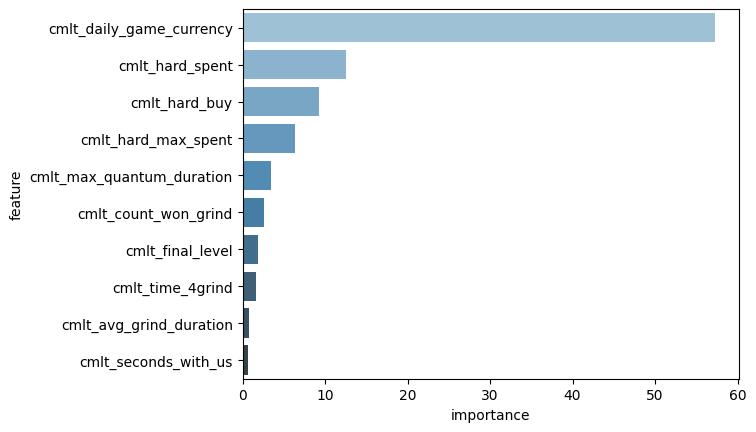

In [43]:
params = {
    'iterations': 200,
    'depth': 3,
    'loss_function': 'RMSE',
    'random_state': 42,
    'l2_leaf_reg': 20,
    'verbose': 50,
    'early_stopping_rounds': 20 
}

model, features = train_model(CatBoostRegressor(**params),
                              X_train, 
                              y_train,
                              5,
                              cross_val=True)

In [44]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [45]:
print('Train SMAPE: ', SMAPE(y_train, y_pred_train))
print('Test SMAPE: ', SMAPE(y_test, y_pred_test))

print('Train RMSE: ',  np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('Test RMSE: ',  np.sqrt(mean_squared_error(y_test, y_pred_test)))

print('Train MSE: ',  mean_absolute_error(y_train, y_pred_train))
print('Test MSE: ',  mean_absolute_error(y_test, y_pred_test))

Train SMAPE:  1.9712079966784144
Test SMAPE:  1.972094884074186
Train RMSE:  7548.218324612637
Test RMSE:  6789.383594217298
Train MSE:  659.8947516777444
Test MSE:  630.2303032772471
